In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.special import boxcox1p

In [2]:
entrenamiento = pd.read_csv('data/train.csv')
prueba = pd.read_csv('data/test.csv')
print ("Tamaño del conjunto de entrenamiento : {}" .format(entrenamiento.shape))
print ("Tamaño del conjunto de prueba : {}" .format(prueba.shape))

# Guardar la columna 'Id'
ID_entrenamiento = entrenamiento['Id']
ID_prueba = prueba['Id']

# Ahora eliminar la columna 'Id' ya que no es necesaria para el proceso de predicción.
entrenamiento.drop("Id", axis = 1, inplace = True)
prueba.drop("Id", axis = 1, inplace = True)

Tamaño del conjunto de entrenamiento : (1460, 81)
Tamaño del conjunto de prueba : (1459, 80)


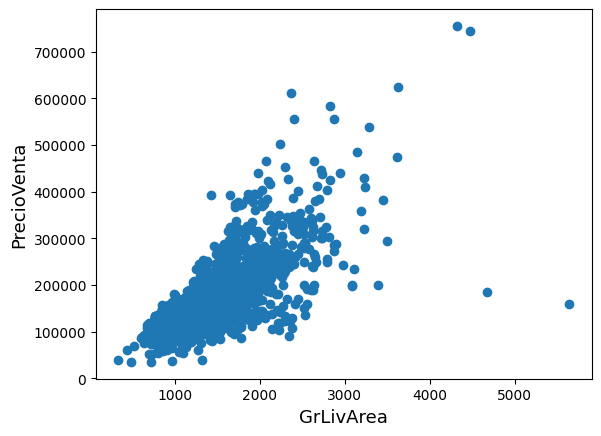

In [3]:
# Eliminación de valores atípicos en GrLivArea como recomienda el autor del conjunto de datos
fig, ax = plt.subplots()
ax.scatter(x = entrenamiento['GrLivArea'], y = entrenamiento['SalePrice'])
plt.ylabel('PrecioVenta', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [4]:
# Eliminando valores atípicos
entrenamiento = entrenamiento.drop(entrenamiento[(entrenamiento['GrLivArea']>4000) & (entrenamiento['SalePrice']<300000)].index)

/tmp/ipykernel_18466/4219314932.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = entrenamiento.corr()
/home/deme/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


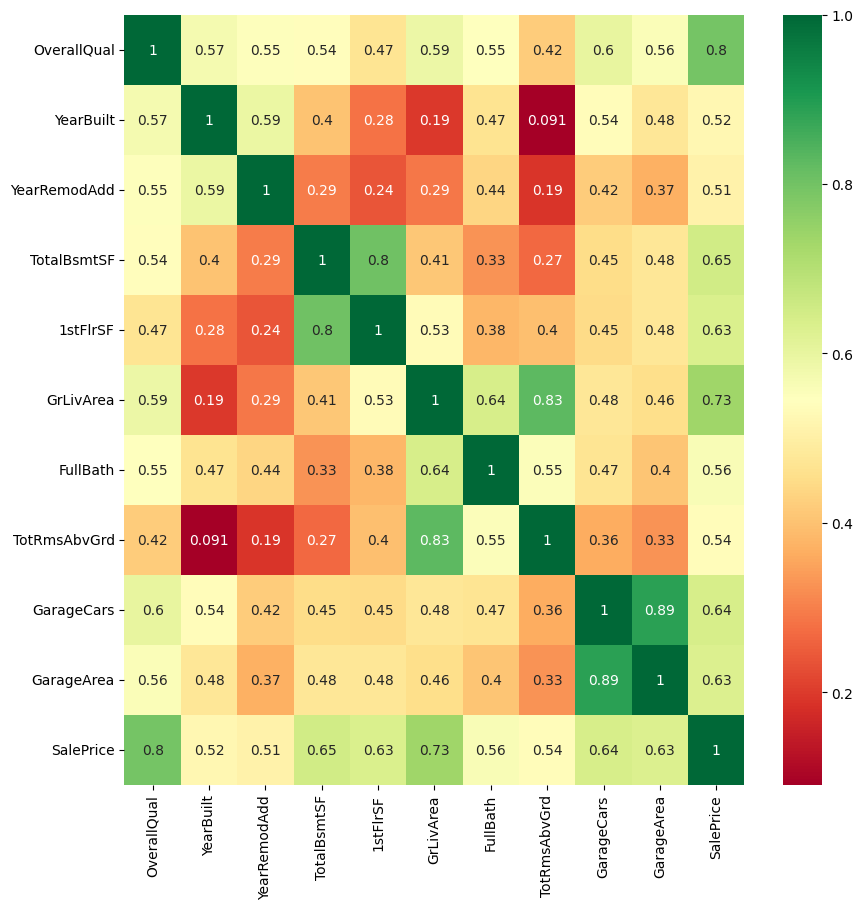

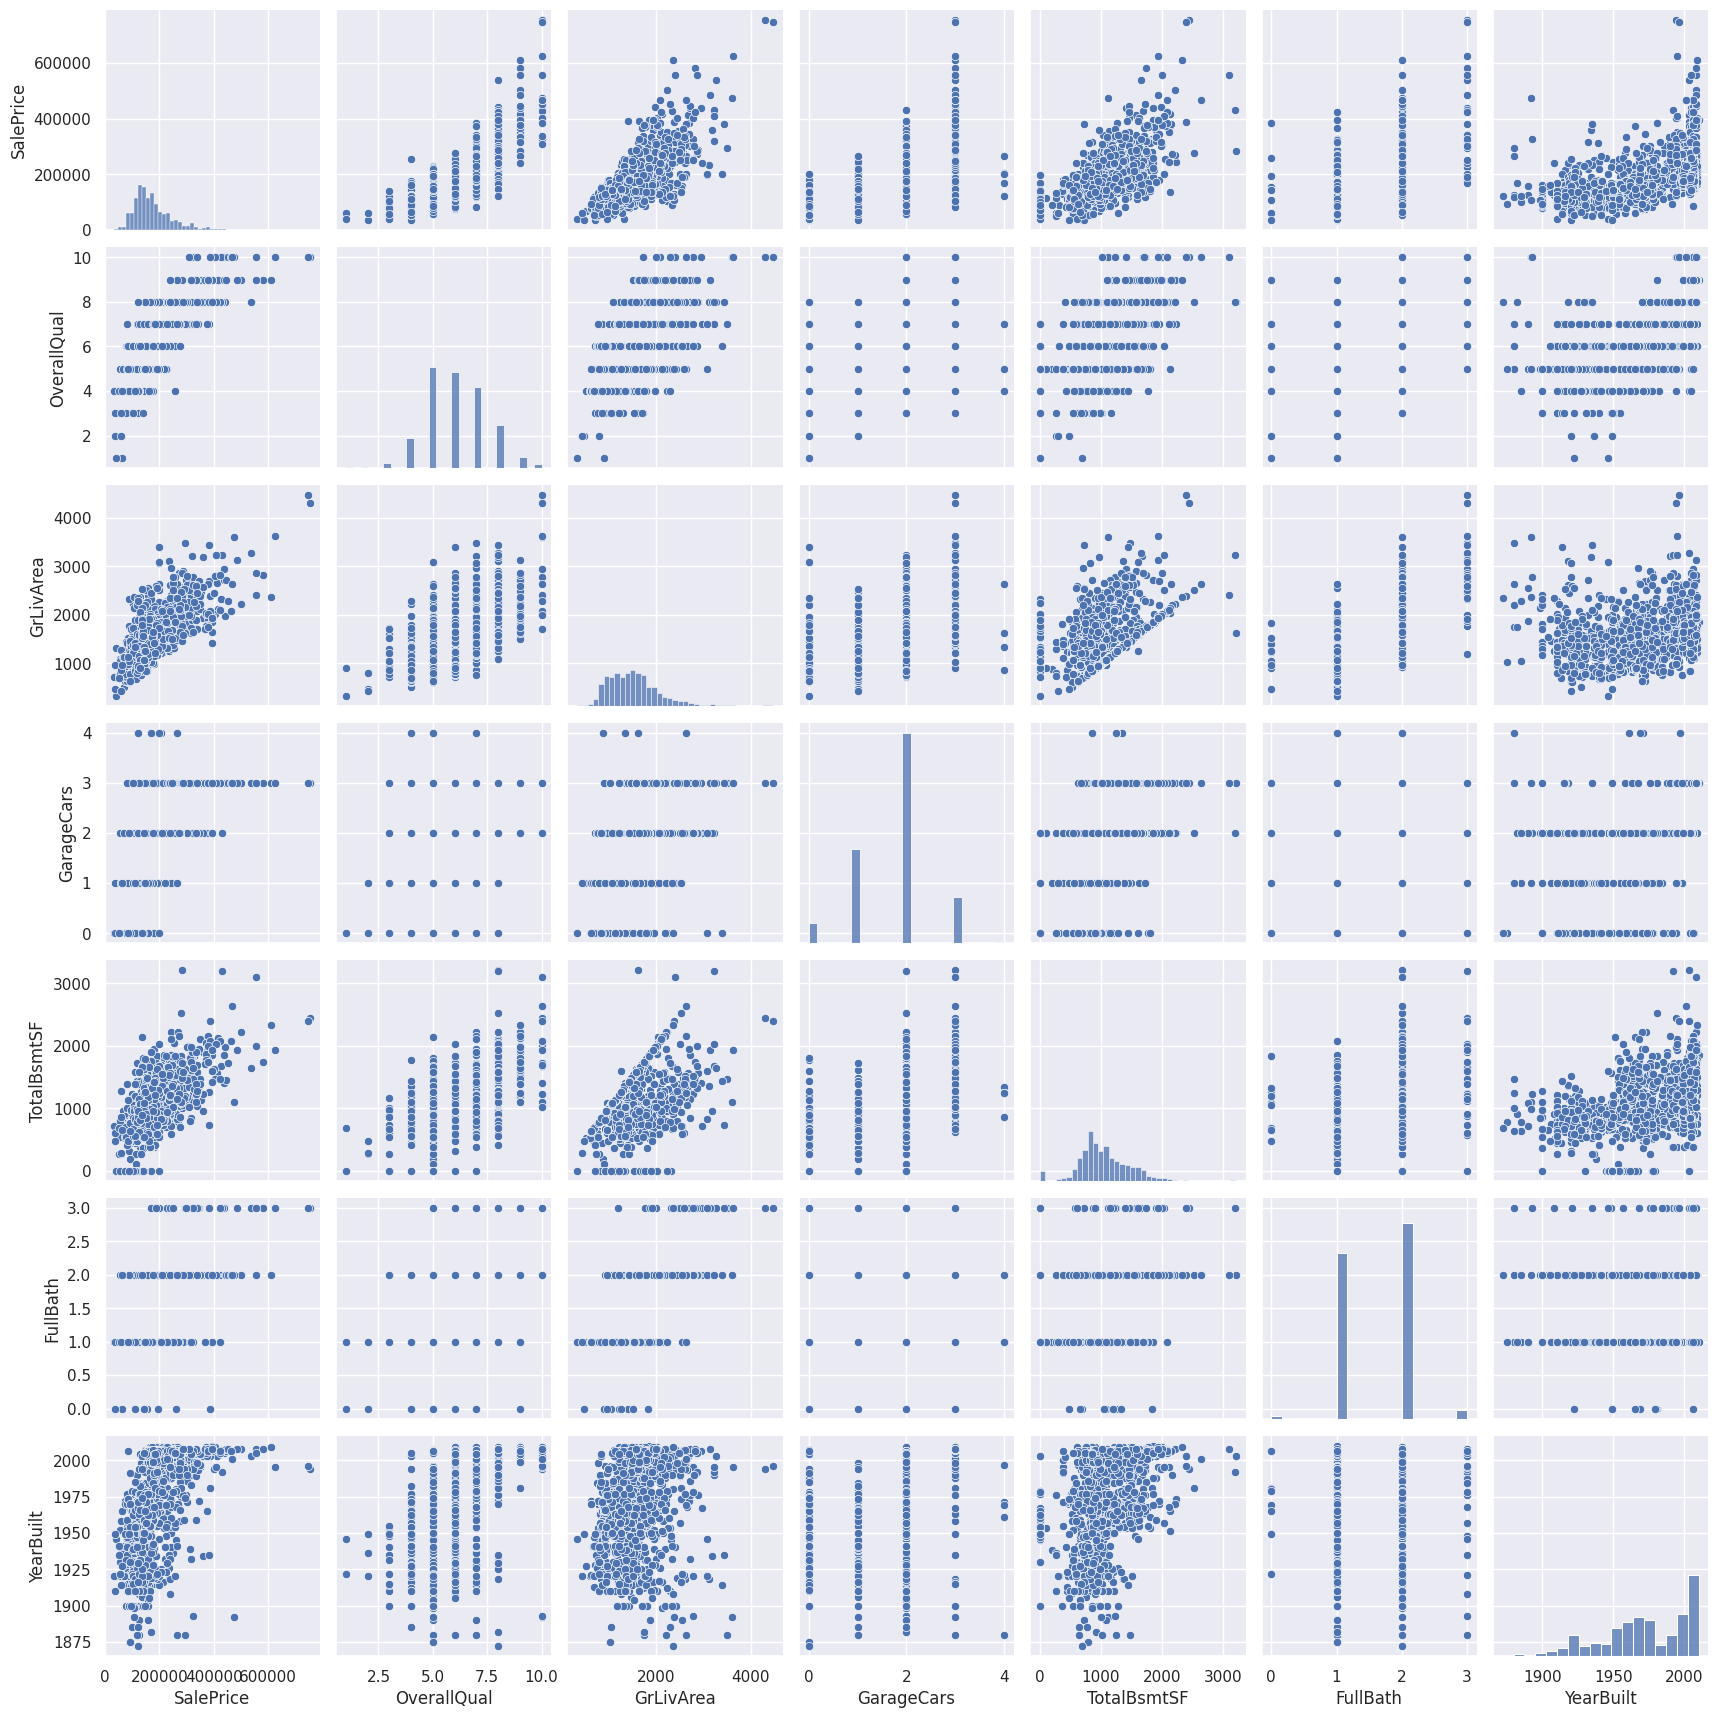

In [5]:
# Análisis de correlación
corrmat = entrenamiento.corr()
caracteristicas_correlacionadas = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(entrenamiento[caracteristicas_correlacionadas].corr(),annot=True,cmap="RdYlGn")

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(entrenamiento[cols], size = 2.5)
plt.show()

/tmp/ipykernel_18466/2801120092.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entrenamiento[col] , fit=norm);



 mu = 180932.92 y sigma = 79467.79



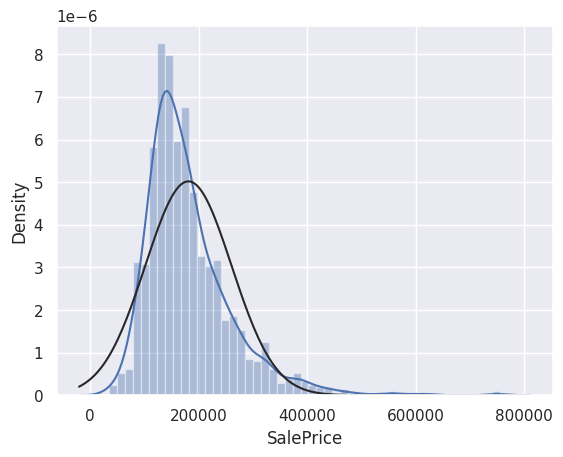

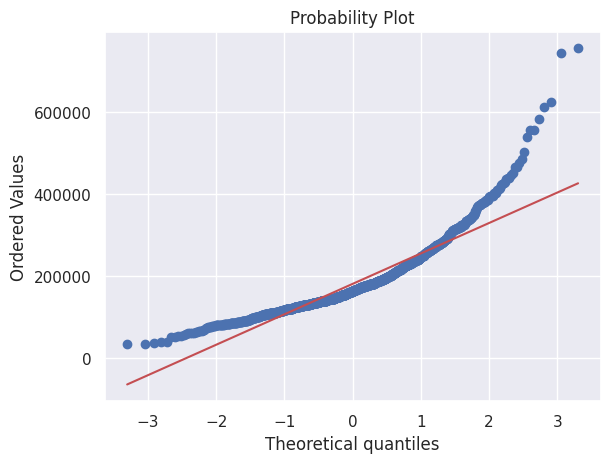

In [6]:
# Transformación de la variable objetivo
def comprobar_asimetria(col):
    sns.distplot(entrenamiento[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(entrenamiento[col], plot=plt)
    (mu, sigma) = norm.fit(entrenamiento[col])
    print( '\n mu = {:.2f} y sigma = {:.2f}\n'.format(mu, sigma))

comprobar_asimetria('SalePrice')

/tmp/ipykernel_18466/2801120092.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entrenamiento[col] , fit=norm);



 mu = 12.02 y sigma = 0.40



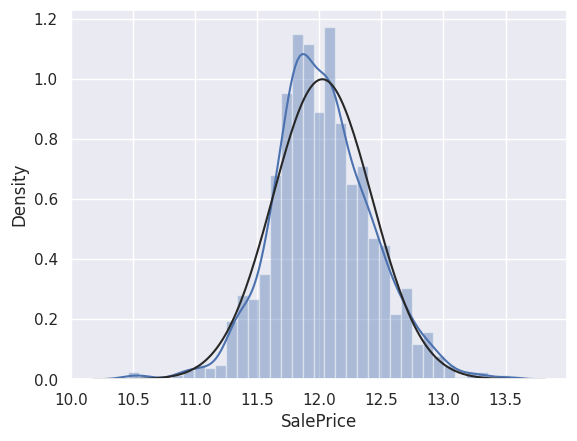

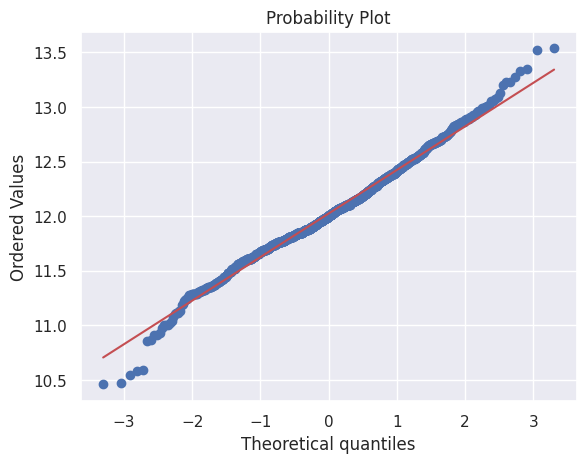

In [7]:
# Aplicamos transformación logarítmica a los datos
entrenamiento["SalePrice"] = np.log1p(entrenamiento["SalePrice"])

comprobar_asimetria('SalePrice')

In [8]:
tamaño_entrenamiento = entrenamiento.shape[0]
tamaño_prueba = prueba.shape[0]
precio_venta = entrenamiento.SalePrice.values
datos_totales = pd.concat((entrenamiento, prueba)).reset_index(drop=True)
datos_totales.drop(['SalePrice'], axis=1, inplace=True)
print("El tamaño de los datos totales es : {}".format(datos_totales.shape))


El tamaño de los datos totales es : (2917, 79)


In [9]:
total = datos_totales.isnull().sum().sort_values(ascending=False)
porcentaje = (datos_totales.isnull().sum()/datos_totales.isnull().count()).sort_values(ascending=False)
datos_faltantes = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
datos_faltantes.head(20)


,Total,Porcentaje
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508


In [10]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
            'MSSubClass'):
    datos_totales[col] = datos_totales[col].fillna('None')

# Para las características numéricas, rellenamos con 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    datos_totales[col] = datos_totales[col].fillna(0)

# Para las variables que tienen una categoría que aparece con más frecuencia, se llenan con la moda
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'):
    datos_totales[col] = datos_totales[col].fillna(datos_totales[col].mode()[0])

# Para 'LotFrontage', consideramos que el área de cada calle conectada a la casa podría tener un área similar a otras casas de su vecindario.
# Llenamos los valores faltantes por la mediana de LotFrontage del vecindario.
datos_totales["LotFrontage"] = datos_totales.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Para las características categóricas con información de orden, se realiza un Label Encoding
from sklearn.preprocessing import LabelEncoder
columnas = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 
            'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 
            'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
            'OverallCond', 'YrSold', 'MoSold')

for col in columnas:
    lbl = LabelEncoder() 
    lbl.fit(list(datos_totales[col].values)) 
    datos_totales[col] = lbl.transform(list(datos_totales[col].values))

# Asegurarse de que no queden valores faltantes
datos_totales_na = (datos_totales.isnull().sum() / len(datos_totales)) * 100
datos_totales_na = datos_totales_na.drop(datos_totales_na[datos_totales_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :datos_totales_na})
missing_data.head()

,Missing Ratio
Utilities,0.068564


In [11]:
#  la superficie total de la casa (TotalSF) que es la suma de TotalBsmtSF, 1stFlrSF y 2ndFlrSF.
datos_totales['TotalSF'] = datos_totales['TotalBsmtSF'] + datos_totales['1stFlrSF'] + datos_totales['2ndFlrSF']

#  transformación de algunas variables numéricas que parecen categóricas
datos_totales['MSSubClass'] = datos_totales['MSSubClass'].apply(str)
datos_totales['OverallCond'] = datos_totales['OverallCond'].astype(str)
datos_totales['YrSold'] = datos_totales['YrSold'].astype(str)
datos_totales['MoSold'] = datos_totales['MoSold'].astype(str)

# onehot con get_dummies de pandas ( vía rápida, existen otras opciones que pueden ser mejores depende del caso)
datos_totales = pd.get_dummies(datos_totales)



In [14]:
# Finalmente, dividimos los datos totales de nuevo en los conjuntos de entrenamiento y prueba originales.
datos_entrenamiento = datos_totales[: tamaño_entrenamiento]
datos_prueba = datos_totales[ tamaño_entrenamiento :]

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dividimos los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(datos_entrenamiento, precio_venta, test_size=0.3) 

# Creamos el modelo
modelo = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)

# Entrenamos el modelo
modelo.fit(X_train, y_train)

# Hacemos predicciones con el conjunto de validación
predicciones = modelo.predict(X_val)

# Calculamos el error cuadrático medio de las predicciones
mse = mean_squared_error(y_val, predicciones)

print("El error cuadrático medio de las predicciones es: {}".format(mse))


El error cuadrático medio de las predicciones es: 0.012633039552241116
